In [68]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np 
import seaborn as sns
import statsmodels as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
from pmdarima.arima import auto_arima # Will conflict with statsmodels when using Google Colab.
from arch import arch_model

sns.set_style('darkgrid')

In [8]:
# Import Data
start = datetime(2000,1,1)
end = datetime(2022,10,30)

cpi = pdr.DataReader('CPIAUCSL', 'fred', start, end)

<AxesSubplot:xlabel='DATE', ylabel='CPIAUCSL'>

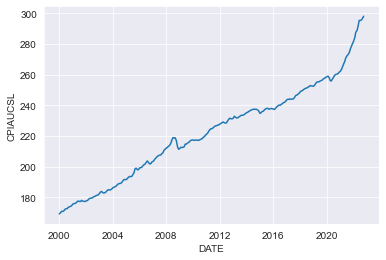

In [9]:
sns.lineplot(data=cpi, x='DATE', y='CPIAUCSL')

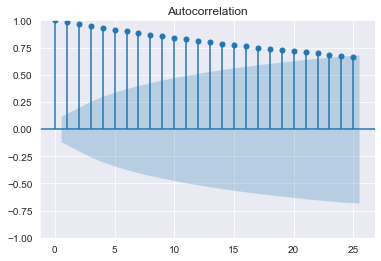

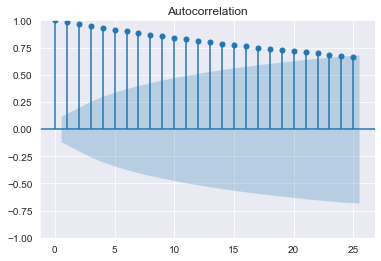

In [10]:
plot_acf(cpi)

/Users/BASTOS/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


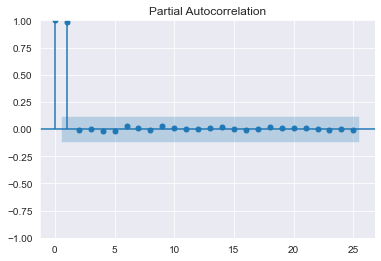

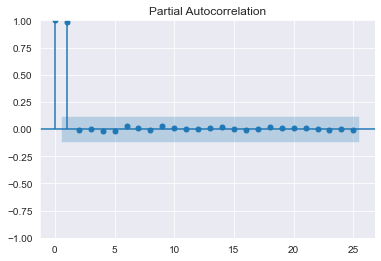

In [11]:
plot_pacf(cpi)

In [19]:
print('ADF Statistic for CPI:', adfuller(cpi, regression='ct', autolag='AIC')[0],'\n','ADF p-value:', adfuller(cpi, regression='ct', autolag='AIC')[1])

ADF Statistic for CPI: 0.5815176639889436 
 ADF p-value: 0.9969691122022722


In [13]:
dcpi = cpi.diff().dropna()

<AxesSubplot:xlabel='DATE', ylabel='CPIAUCSL'>

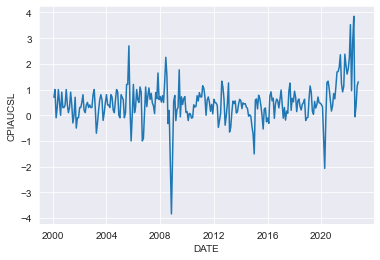

In [14]:
sns.lineplot(data=dcpi, x='DATE', y='CPIAUCSL')

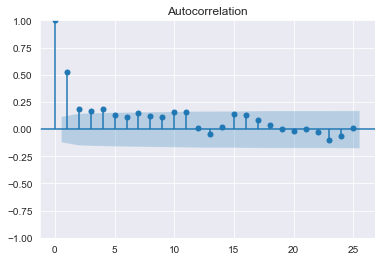

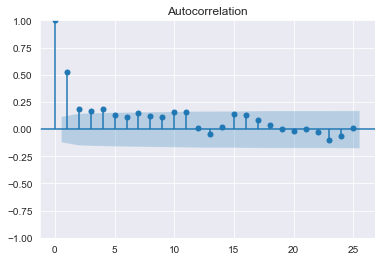

In [15]:
plot_acf(dcpi)

/Users/BASTOS/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


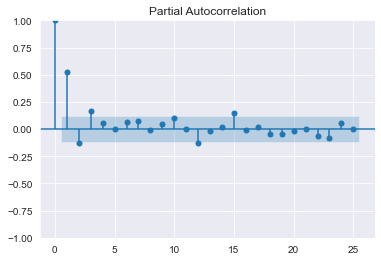

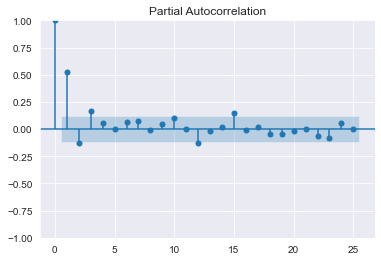

In [16]:
plot_pacf(dcpi)

In [17]:
adfuller(dcpi) # Second line gives p-value 

(-6.61150288531557,
 6.35998751210736e-09,
 2,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 500.0421391685826)

In [18]:
identify_arima = auto_arima(cpi,m=12, max_p = 24, max_q=24, max_n_jobs = -1, trend = 'ct', information_criterion='aic')
print(identify_arima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  274
Model:             SARIMAX(0, 2, 3)x(0, 0, [1], 12)   Log Likelihood                -253.763
Date:                              Wed, 16 Nov 2022   AIC                            521.527
Time:                                      09:55:01   BIC                            546.767
Sample:                                  01-01-2000   HQIC                           531.660
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0079      0.008     -0.936      0.349      -0.025       0.009
drift       8.415e-

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

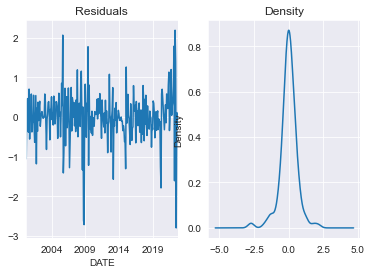

In [42]:
resid_cpi = identify_arima.resid()
resid_cpi = resid_cpi[2:]
fig, ax = plt.subplots(1,2)
resid_cpi.plot(title= 'Residuals',ax=ax[0])
resid_cpi.plot(title='Density',kind='kde',ax=ax[1])

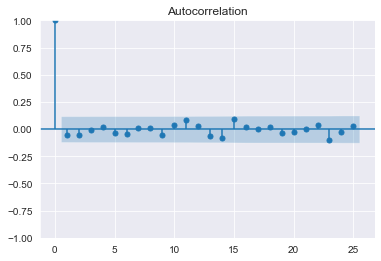

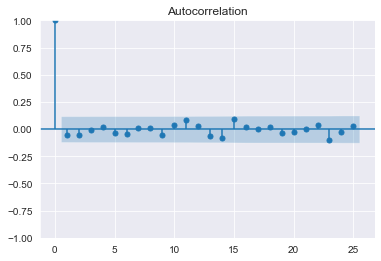

In [43]:
plot_acf(resid_cpi)

/Users/BASTOS/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


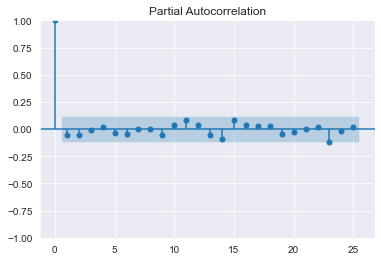

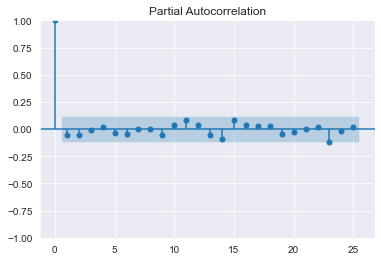

In [44]:
plot_pacf(resid_cpi)

The null hypothesis is that residuals are not stationary. Since we reject the null hypothesis, we are confident that the results are stationary.

In [45]:
print('ADF Statistic for CPI residuals:', adfuller(resid_cpi, regression='ct', autolag='AIC')[0],'\n',
      'ADF p-value for CPI residuals:', adfuller(resid_cpi, regression='ct', autolag='AIC')[1])

ADF Statistic for CPI residuals: -17.293805962754075 
 ADF p-value for CPI residuals: 0.0


<AxesSubplot:xlabel='DATE'>

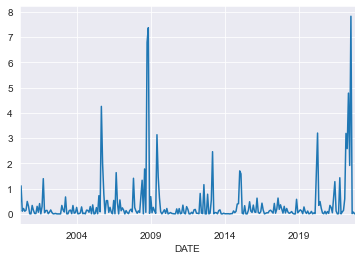

In [46]:
resid2_cpi = resid_cpi**2
resid2_cpi.plot()

/Users/BASTOS/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


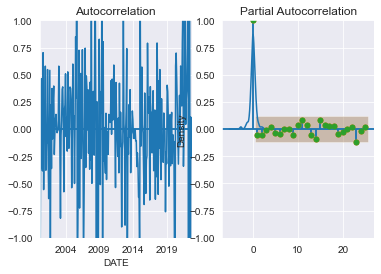

In [56]:
plot_acf(resid_cpi, ax=ax[0])
plot_pacf(resid_cpi, ax=ax[1])

In [57]:
kpss(resid2_cpi)

/Users/BASTOS/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.16246631337955433,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [72]:
het_model = smf.ols('resid2_cpi ~ resid2_cpi.shift(1) + resid2_cpi.shift(2)', resid2_cpi).fit()
print(het_model.summary())

                            OLS Regression Results                            
Dep. Variable:             resid2_cpi   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     22.87
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           6.81e-10
Time:                        10:39:00   Log-Likelihood:                -353.85
No. Observations:                 270   AIC:                             713.7
Df Residuals:                     267   BIC:                             724.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2079    

In [78]:
sm.stats.diagnostic.het_arch(resid_cpi, nlags=4) # It automatically take the squares

(39.46838670138909,
 5.5748844095130854e-08,
 11.355306113493867,
 1.624116785029134e-08)

In [79]:
archm = arch_model(dcpi[1:], mean='constant', lags = 2, vol = 'ARCH', p=1).fit()
print(archm.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1340.2281924688284
Iteration:      2,   Func. Count:     12,   Neg. LLF: 36096.84706073333
Iteration:      3,   Func. Count:     18,   Neg. LLF: 252.97530899382483
Iteration:      4,   Func. Count:     23,   Neg. LLF: 264.3659547058114
Iteration:      5,   Func. Count:     29,   Neg. LLF: 247.4434587050354
Iteration:      6,   Func. Count:     33,   Neg. LLF: 247.4434430834005
Iteration:      7,   Func. Count:     36,   Neg. LLF: 247.44344308340274
Optimization terminated successfully    (Exit mode 0)
            Current function value: 247.4434430834005
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:               CPIAUCSL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likel

In [80]:
garchm = arch_model(dcpi[1:], mean='AR', lags = 2, vol = 'GARCH', p=1).fit()
print(garchm.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 25159.088205537377
Iteration:      2,   Func. Count:     19,   Neg. LLF: 20260.621452443458
Iteration:      3,   Func. Count:     29,   Neg. LLF: 38092.1831624315
Iteration:      4,   Func. Count:     37,   Neg. LLF: 2426903.1978697404
Iteration:      5,   Func. Count:     46,   Neg. LLF: 229.5941914280474
Iteration:      6,   Func. Count:     55,   Neg. LLF: 306.83233194658453
Iteration:      7,   Func. Count:     64,   Neg. LLF: 270.93651136408215
Iteration:      8,   Func. Count:     73,   Neg. LLF: 215.40678936994414
Iteration:      9,   Func. Count:     81,   Neg. LLF: 215.26695995861235
Iteration:     10,   Func. Count:     88,   Neg. LLF: 215.26508933605626
Iteration:     11,   Func. Count:     95,   Neg. LLF: 215.26507612412877
Iteration:     12,   Func. Count:    101,   Neg. LLF: 215.26507612422745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 215.26507612412877
            Iterat

In [77]:
for i in range(0,5):
    smf.ols('resid2_cpi ~ resid2_cpi.shift(1) + resid2_cpi.shift(2)', resid2_cpi).fit().aic

713.6932400556741